# 09_05: summarizing and visualizing categorical data

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

We move on to categorical variables... those that can take a finite and discrete set of values.

How do we describe variation in categorical variables? Well, with tables, of course!

We switch from gapminder to the "Whickham" dataset discussed by Kaplan in his excellent textbook "Statistical modeling". The table records interviews with women in Whickham, England, in 1973, who were asked if they were smokers. The interviews were followed up 20 years later, when it was recorded if the women were still alive. 

The categorical variables in this case, smoker and outcome, are both binary (yes/no).

In [19]:
smoking = pd.read_csv('whickham.csv')

# encoding the variables explicitly as categories will save memory and CPU
smoking.smoker = smoking.smoker.astype('category')
smoking.outcome = smoking.outcome.astype('category')

In [20]:
smoking.head()

,age,smoker,outcome
0,23,Yes,Alive
1,18,Yes,Alive
2,71,Yes,Dead
3,67,No,Alive
4,64,No,Alive


Using `value_counts()`, we can tally the explanatory (smoker) and response (outcome) variables separately. This does not tell us much, other than both pairs of groups are represented fairly well: smokers and nonsmokers, women who survived for twenty years and those who didn't. Wrapping with a `DataFrame` makes the output a little prettier.

In [28]:
smoking.smoker.value_counts()

smoker
No     732
Yes    582
Name: count, dtype: int64

In [29]:
smoking.outcome.value_counts()

outcome
Alive    945
Dead     369
Name: count, dtype: int64

If we want to see the values as fractions of the total number of records, we add `normalize=True`. These fractions are known in statistics as **proportions**.

In [31]:
smoking.outcome.value_counts(normalize=True)

outcome
Alive    0.719178
Dead     0.280822
Name: proportion, dtype: float64

We are looking for an **association**: that is, we wish to evaluate a claim that the groups of smokers and nonsmokers are different with regards to their longevity. So we break down the proportion of outcomes by smoker group.

In [38]:
# specifying observer=True includes only categories that are represented in the data; here it avoids a warning
smoking.groupby("smoker", observed=True).outcome.value_counts(normalize=True)

smoker  outcome
No      Alive      0.685792
        Dead       0.314208
Yes     Alive      0.761168
        Dead       0.238832
Name: proportion, dtype: float64

This series has a two-level multiindex. We move one of the levels to a column using unstack

In [45]:
smoking.groupby("smoker", observed=True).outcome.value_counts(normalize=True).unstack()

outcome,Alive,Dead
smoker,,
No,0.685792,0.314208
Yes,0.761168,0.238832


This table is a bit surprising! It seems that smoking improves the chance of being alive twenty years later!

The problem is that we're not **controlling** for other variables, such as age. If smokers are younger on average at the beginning of the study, then it stands to reason that more of them would be alive after twenty years, no matter what.

To investigate this puzzle, we use a method that statisticians call **stratification**. We divide the people in the table (that is, our cases) into age groups. The pandas function to do this is `cut`. We see that the result is another categorical variable.

In [66]:
smoking['agegroup'] = pd.cut(smoking.age, bins=[15,40,65,90])
smoking['agegroup']

0       (15, 40]
1       (15, 40]
2       (65, 90]
3       (65, 90]
4       (40, 65]
          ...   
1309    (15, 40]
1310    (15, 40]
1311    (15, 40]
1312    (40, 65]
1313    (40, 65]
Name: agegroup, Length: 1314, dtype: category
Categories (3, interval[int64, right]): [(15, 40] < (40, 65] < (65, 90]]

This time, we group the data first by ageGroup, then by smoker status.

In each age group, nonsmokers have better life expectancy. In fact, these data represent an example of **Simpson's paradox**, a phenomenon in probability and statistics in which a trend appears in several different groups of data but disappears or reverses when these groups are combined.

In [67]:
smoking.groupby(['agegroup', 'smoker'], observed=True).outcome.value_counts(normalize=True).unstack()

outcome             Alive      Dead
agegroup smoker                    
(15, 40] No      0.969900  0.030100
         Yes     0.958506  0.041494
(40, 65] No      0.739130  0.260870
         Yes     0.705479  0.294521
(65, 90] No      0.138889  0.861111
         Yes     0.122449  0.877551

Now we plot!

We start by plotting counts separately for our response and explanatory variables.

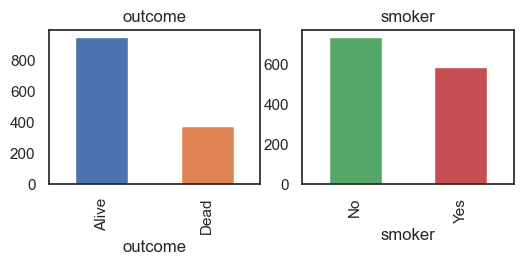

In [92]:
pp.figure(figsize=(6,2))

pp.subplot(1,2,1)
smoking.outcome.value_counts().plot(kind='bar', color=['C0','C1']) 
pp.title('outcome')

pp.subplot(1,2,2)
smoking.smoker.value_counts().plot(kind='bar', color=['C2','C3'])
pp.title('smoker');

The bars could be horizontal...

<Axes: ylabel='outcome'>

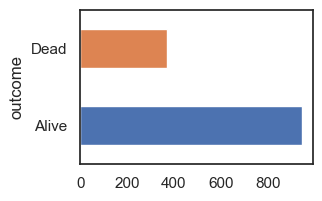

In [96]:
smoking.outcome.value_counts().plot(kind='barh', color=['C0','C1'], figsize=(3,2)) 

...or even pie charts.

<Axes: ylabel='count'>

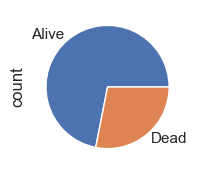

In [97]:
smoking.outcome.value_counts().plot(kind='pie', color=['C0','C1'], figsize=(3,2)) 

Now let's try to break up the visualization so that we show the outcome by smoker status. We have already created a table grouped by outcome. Plotting as a bar will handle that just fine.

In [116]:
grouped = smoking.groupby("smoker", observed=True).outcome.value_counts(normalize=True).unstack()
grouped

outcome,Alive,Dead
smoker,,
No,0.685792,0.314208
Yes,0.761168,0.238832


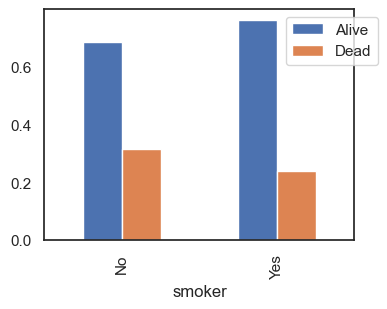

In [125]:
axes = grouped.plot(kind='bar', figsize=(4,3))
axes.legend(loc='upper right', bbox_to_anchor=(1.1, 1)); # fix legend location

We can also do a stacked histogram!

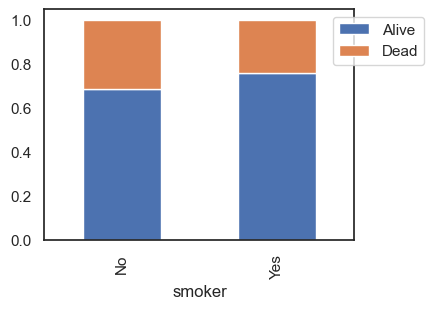

In [130]:
axes = grouped.plot(kind='bar', figsize=(4,3), stacked=True)
axes.legend(loc='upper right', bbox_to_anchor=(1.25, 1)); # fix legend location

Hm, this plot supports the original suspicious finding that smoking improves the outcome. Now let's do stratification.

In [183]:
regrouped = smoking.groupby(['agegroup', 'smoker'], observed=True).outcome.value_counts(normalize=True).unstack()
regrouped

outcome             Alive      Dead
agegroup smoker                    
(15, 40] No      0.969900  0.030100
         Yes     0.958506  0.041494
(40, 65] No      0.739130  0.260870
         Yes     0.705479  0.294521
(65, 90] No      0.138889  0.861111
         Yes     0.122449  0.877551

A decent first try, but confusing, with the mixed labels at the bottom.

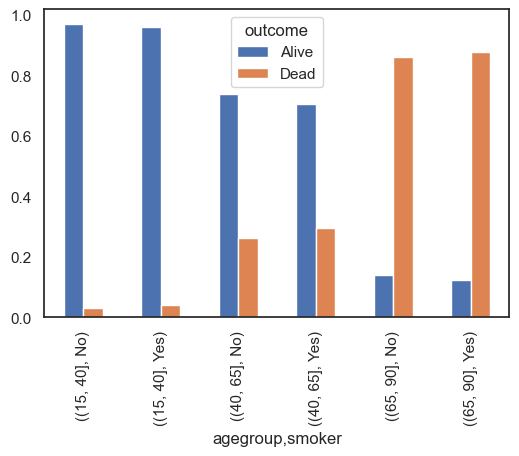

In [184]:
regrouped.plot(kind='bar', figsize=(6,4));

We can do better by keeping only the fraction of people who are alive.

In [172]:
regrouped = smoking.groupby(['agegroup', 'smoker'], observed=True) \
                   .outcome.value_counts(normalize=True).loc[:,:,'Alive'].unstack()

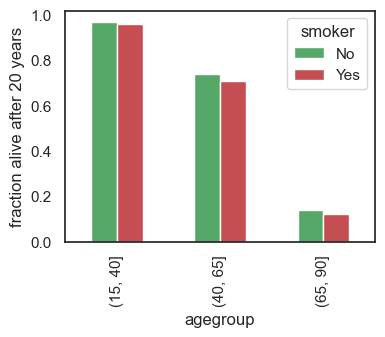

In [181]:
regrouped.plot(kind='bar', color=['C2','C3'], figsize=(4,3));
pp.ylabel('fraction alive after 20 years');

Here we see that in every age group nonsmokers have a slight edge in outcomes. Simpson's paradox at work.